# **1. Transfer Learning**
---

## **1.1 Transfer Learning in Deep Learning**

Transfer learning is a technique where a neural network model trained on one task is reused as the starting point for a new, but related, task. This is especially useful in deep learning, where training models from scratch can be very data- and time-intensive.

#### How It Works:
1. **Pretrained Deep Model**:
   - Start with a deep neural network, like a convolutional neural network (CNN), which has been trained on a large dataset (e.g., ImageNet, containing millions of images).
  
2. **Reuse the Layers**:
   - Instead of training a new model from scratch, use most of the layers from the pretrained model. These layers have learned useful features (such as edges, textures, and shapes) that are beneficial across different tasks.

3. **Adapt to New Task**:
   - For your specific task (e.g., classifying different types of medical images), modify only the last few layers of the model. Fine-tune these layers on your dataset, or retrain all layers briefly to tailor the model to your new data.

#### Benefits:
- **Saves Time and Resources**: Reusing a pretrained model reduces the data and computational power needed.
- **Improves Performance**: Transfer learning often results in better performance on tasks with limited labeled data.


For example, we can take the patterns a computer vision model has learned from datasets such as [ImageNet](https://www.image-net.org/) (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a [language model](https://developers.google.com/machine-learning/glossary#masked-language-model) (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-example-overview.png" alt="transfer learning overview on different problems" width=900/>




Transfer learning is widely used in deep learning applications like image recognition, natural language processing, and more.


And there are several places you can find pretrained models to use for your own problems.

| **Location** | **What's there?** | **Link(s)** |
| ----- | ----- | ----- |
| **PyTorch domain libraries** | Each of the PyTorch domain libraries (`torchvision`, `torchtext`) come with pretrained models of some form. The models there work right within PyTorch. | [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [`torchtext.models`](https://pytorch.org/text/main/models.html), [`torchaudio.models`](https://pytorch.org/audio/stable/models.html), [`torchrec.models`](https://pytorch.org/torchrec/torchrec.models.html) |
| **HuggingFace Hub** | A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too. | https://huggingface.co/models, https://huggingface.co/datasets |
| **`timm` (PyTorch Image Models) library** | Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features. | https://github.com/rwightman/pytorch-image-models|
| **Paperswithcode** | A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks. | https://paperswithcode.com/ |

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-where-to-find-pretrained-models.png" alt="different locations to find pretrained neural network models" width=900/>


## **2.1 Getting setup**

To save us writing extra code, we're going to be leveraging some of the Python scripts (such as `data_setup.py` and `engine.py`) we created in the previous section, [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


Specifically, we're going to download the [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the `pytorch-deep-learning` repository (if we don't already have it).

In [18]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [19]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from ref import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    # !git clone https://github.com/mrdbourke/pytorch-deep-learning
    # !mv pytorch-deep-learning/going_modular .
    # !rm -rf pytorch-deep-learning
    from ref import data_setup, engine



In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## **2.2 Get Data**
Before we can start to use **transfer learning**, we'll need a dataset.

To see how transfer learning compares to our previous attempts at model building, we'll download the same dataset we've been using for FoodVision Mini.

Let's write some code to download the [`pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) dataset from the course GitHub and then unzip it.

We can also make sure if we've already got the data, it doesn't redownload.

In [21]:
import os
import zipfile
from pathlib import Path
import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
      request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
      print("Downloading pizza, steak, sushi data...")
      f.write(request.content)
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

    os.remove(data_path / "pizza_steak_sushi.zip")



data/pizza_steak_sushi directory exists.


In [30]:
# data_path = Path("data/")
# image_path = data_path / "pizza_steak_sushi"

# with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
#   request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
#   print("Downloading pizza, steak, sushi data...")
#   f.write(request.content)

# with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
#   print("Unzipping pizza, steak, sushi data...")
#   zip_ref.extractall(image_path)
#   os.remove(data_path / "pizza_steak_sushi.zip")

Unzipping pizza, steak, sushi data...


In [22]:
# setup dirs

train_dir = image_path / "train"
test_dir = image_path / "test"

## **2.3 Creating Datasets and DataLoaders**

When using a pretrained model in PyTorch, it’s crucial to ensure that **your custom data is processed in the same way as the data used to train the model originally**. This maintains consistency and maximizes model performance.

### Important Update on Data Transforms

> **Note:** Starting with `torchvision` v0.13+, there’s a new way to set up data transforms for pretrained models. This guide explains both the older "manual creation" approach and the newer "auto creation" approach.

### Pre-`torchvision` v0.13+ Data Preparation

Before `torchvision` v0.13+, preparing data for pretrained models in `torchvision.models` required the following:

1. **Image Normalization**:
   - All pretrained models expect **3-channel RGB images** with dimensions `(3 x H x W)`, where **H** and **W** are at least 224.
   - The images should be scaled between `[0, 1]` and then normalized using:
     ```python
     mean = [0.485, 0.456, 0.406]
     std = [0.229, 0.224, 0.225]
     ```

2. **Code for Normalization**:
   ```python
   normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
   ```                      
## Applying the Required Transforms

To match the expectations of a pretrained model, we can apply a sequence of transforms:

| **Step** | **Required Transform** | **Code** |
| -------- | ---------------------- | -------- |
| 1 | Resize images to `[batch_size, 3, H, W]` where H and W are at least 224 | `torchvision.transforms.Resize()` and `torch.utils.data.DataLoader()` |
| 2 | Scale pixel values to range `[0, 1]` | `torchvision.transforms.ToTensor()` |
| 3 | Normalize mean to `[0.485, 0.456, 0.406]` across channels | `torchvision.transforms.Normalize(mean=...)` |
| 4 | Normalize standard deviation to `[0.229, 0.224, 0.225]` across channels | `torchvision.transforms.Normalize(std=...)` |

> **Note:** Some models in `torchvision.models` might require different image sizes (e.g., `[3, 240, 240]`). Check the specific model’s documentation for its required input dimensions.

### Explanation of Mean and Standard Deviation

> **Question:** *Why are these specific mean and standard deviation values used?*
>
> These values were calculated based on a subset of the ImageNet dataset, ensuring a consistent distribution of pixel values across images. While neural networks can learn optimal data distributions during training, presetting these values can help models perform better, faster.

### Composing the `torchvision.transforms`

Now, let’s define a sequence of `torchvision.transforms` to apply these transformations to our data.


In [23]:
# create transform pipeline manually

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])


> **Note:** I've included this manual creation of transforms in this notebook because you may come across resources that use this style. It's also important to note that because these transforms are manually created, they're also infinitely customizable. So if you wanted to included data augmentation techniques in your transforms pipeline, you could.

In [31]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir= train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ac8c623b940>,
 ['pizza', 'steak', 'sushi'])


But as of `torchvision` v0.13+, an automatic transform creation feature has been added.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:
    
```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

Where,
* `EfficientNet_B0_Weights` is the model architecture weights we'd like to use (there are many different model architecture options in `torchvision.models`).
* `DEFAULT` means the *best available* weights (the best performance in ImageNet).
    * **Note:** Depending on the model architecture you choose, you may also see other options such as `IMAGENET_V1` and `IMAGENET_V2` where generally the higher version number the better. Though if you want the best available, `DEFAULT` is the easiest option. See the [`torchvision.models` documentation](https://pytorch.org/vision/main/models.html) for more.
    

In [31]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_weights.DEFAULT
weights

> This line of code is assigning the pretrained model weights for EfficientNet-B0 (specifically the default ImageNet weights) to the variable weights. You can later use these weights to initialize a model, making use of the knowledge learned from the ImageNet dataset without having to train the model from scratch.

> `weights` is a variable holding the pretrained parameters of the model.`model` is the actual architecture, which you can load using the pretrained weights (weights).

```python
weights = torchvision.models.EfficientNet_B0_weights.DEFAULT
# 1. Load the pretrained model with the weights
model = models.efficientnet_b0(weights=weights)

# 2. Get the transformations that were used to preprocess the data for training the model
auto_transforms = weights.transforms()
```

In [32]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [33]:
# Get the transformations that were used to preprocess the data for training the model
auto_transforms = weights.transforms()

## **2.4 Getting a pretrained Model**


Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification).

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... |
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` |
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... |
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... |
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` |

###  Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. `efficientnet_b0()` -> `efficientnet_b1()` -> `efficientnet_b7()`) means *better performance* but a *larger* model.

You might think better performance is *always better*, right?

That's true but **some better performing models are too big for some devices**.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, as [*The Bitter Lesson*](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) states, you'd likely take the biggest, most compute hungry model you can.

Understanding this **performance vs. speed vs. size tradeoff** will come with time and practice.

For me, I've found a nice balance in the `efficientnet_bX` models.

As of May 2022, [Nutrify](https://nutrify.app) (the machine learning powered app I'm working on) is powered by an `efficientnet_b0`.

[Comma.ai](https://comma.ai/) (a company that makes open source self-driving car software) [uses an `efficientnet_b2`](https://geohot.github.io/blog/jekyll/update/2021/10/29/an-architecture-for-life.html) to learn a representation of the road.

> **Note:** Even though we're using `efficientnet_bX`, it's important not to get too attached to any one architecture, as they are always changing as new research gets released. Best to experiment, experiment, experiment and see what works for your problem.

The pretrained model we're going to be using is [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0).

The architecture is from the paper *[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)*.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-effnet-b0-feature-extractor.png" alt="efficienet_b0 from PyTorch torchvision feature extraction model" width=900/>

In [34]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model   = torchvision.models.efficientnet_b0(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 66.9MB/s]


If we print the model, we get something similar to the following:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnetb0-model-print-out.png" alt="output of printing the efficientnet_b0 model from torchvision.models" width=900/>

Our `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default).

To learn more about our model, let's use `torchinfo`'s [`summary()` method](https://github.com/TylerYep/torchinfo#documentation).

To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`, though [other variants of `efficientnet_bX` have different input sizes](https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93).
    * **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `summary()` or your models.
 * `col_names` - the various information columns we'd like to see about our model.
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [36]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

| **Column**              | **Explanation**                                                                                                                                               |
|-------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Layer (type (var_name))** | Displays the type of layer (e.g., `Conv2d`, `MBConv`, `Linear`) and the name (e.g., `0`, `1`, etc.) corresponding to the layer.                        |
| **Input Shape**          | Shows the shape of the input to that layer. For example, `[32, 3, 224, 224]` means a batch size of 32, 3 color channels (RGB), and 224x224 pixel images. |
| **Output Shape**         | Shows the shape of the output after the layer processes the input. For example, `[32, 1280, 7, 7]` means 32 samples, 1280 channels, and 7x7 spatial dimensions. |
| **Param #**              | Number of parameters in the layer (i.e., learnable weights). Layers like `Conv2d` and `Linear` will have a number, while `SiLU` and others will have `--` (no parameters). |
| **Trainable**            | Indicates whether the parameters in this layer are trainable (can be updated during training). `True` means the layer's parameters are trainable.       |


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-frozen-layers.png" alt="output of torchinfo.summary() after freezing multiple layers in our model and changing the classifier head" width=900/>

### Explanation of AdaptiveAvgPool2d Layer

- **Input Shape**: `[32, 1280, 7, 7]`
  - `32` is the batch size.
  - `1280` is the number of channels.
  - `7x7` are the spatial dimensions (height and width).

- **Output Shape**: `[32, 1280, 1, 1]`
  - `32` remains the batch size.
  - `1280` is the same number of channels.
  - `1x1` is the reduced spatial size.

### Function of AdaptiveAvgPool2d:
- The `AdaptiveAvgPool2d` layer reduces the spatial dimensions (7x7) to a fixed size (1x1) by calculating the **average** of the 7x7 region for each channel.
- This operation helps in preparing the feature map for the final fully connected layers by reducing spatial resolution while retaining the depth (number of channels).
- The output for each channel is a single value (1x1), calculated from the average of all the 7x7 pixels in that channel.

### Why this happens:
- The pooling operation reduces spatial dimensions but does not affect the number of channels, thus transforming `[32, 1280, 7, 7]` to `[32, 1280, 1, 1]`.


In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

The `train()` function is in the [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py) script inside the [`going_modular` directory](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular/going_modular).

Let's see how long it takes to train our model for 5 epochs.

> **Note:** We're only going to be training the parameters `classifier` here as all of the other parameters in our model have been frozen.

In [45]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()
results = engine.train(model = model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.9919 | train_acc: 0.4531 | test_loss: 2396.1278 | test_acc: 0.3400
Epoch: 2 | train_loss: 1.9504 | train_acc: 0.4492 | test_loss: 15661.8314 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.3936 | train_acc: 0.4727 | test_loss: 48.1543 | test_acc: 0.4413
Epoch: 4 | train_loss: 1.2284 | train_acc: 0.5508 | test_loss: 55.7297 | test_acc: 0.5312
Epoch: 5 | train_loss: 0.8917 | train_acc: 0.6719 | test_loss: 6.9755 | test_acc: 0.5322
[INFO] Total training time: 347.770 seconds


at lr = 0.001
```
100%
 5/5 [06:40<00:00, 80.51s/it]
Epoch: 1 | train_loss: 2.1108 | train_acc: 0.7031 | test_loss: 1.5341 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.4177 | train_acc: 0.8477 | test_loss: 0.8257 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.0628 | train_acc: 0.9883 | test_loss: 0.2376 | test_acc: 0.9688
Epoch: 4 | train_loss: 0.2857 | train_acc: 0.8555 | test_loss: 0.3462 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.3749 | train_acc: 0.8555 | test_loss: 1.1959 | test_acc: 0.8561
[INFO] Total training time: 400.341 seconds
```

With an `efficientnet_b0` backbone, our model achieves almost 85%+ accuracy on the test dataset, almost *double* what we were able to achieve with TinyVGG.

Not bad for a model we downloaded with a few lines of code.

## **2.5 Evalaute model by plotting loss curve**

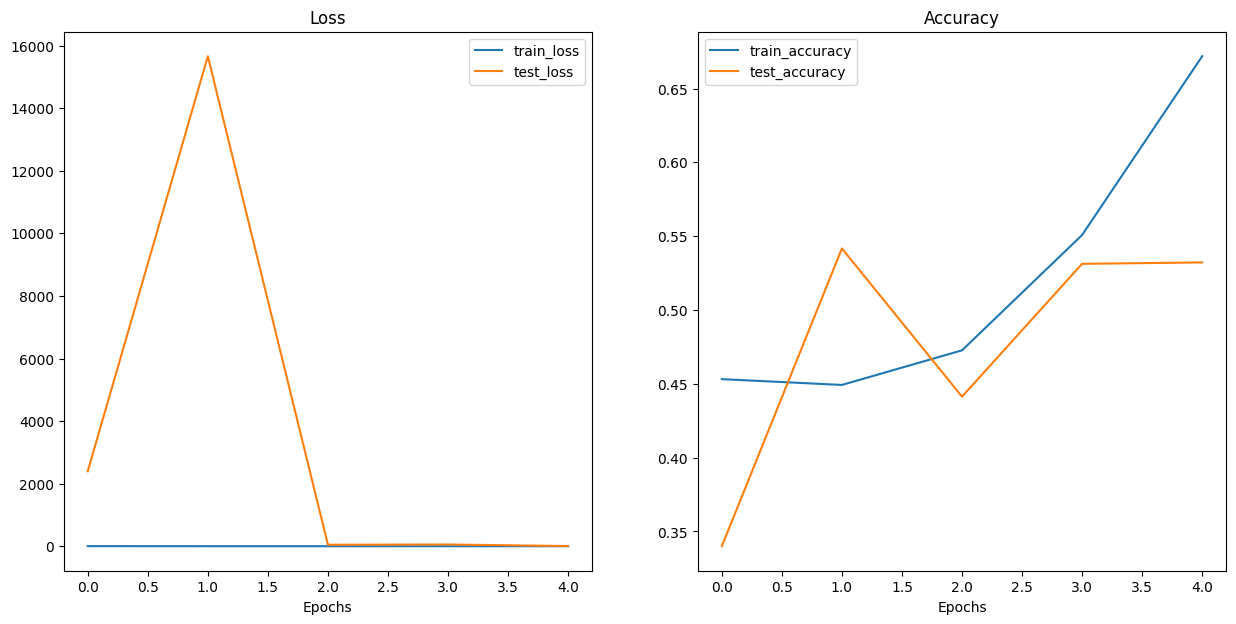

In [46]:
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldnot find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)

Those are some excellent looking loss curves!

It looks like the loss for both datasets (train and test) is heading in the right direction.

The same with the accuracy values, trending upwards.

That goes to show the power of **transfer learning**. Using a pretrained model often leads to pretty good results with a small amount of data in less time.

I wonder what would happen if you tried to train the model for longer? Or if we added more data?

> **Question:** Looking at the loss curves, does our model look like it's overfitting or underfitting? Or perhaps neither? Hint: Check out notebook [04. PyTorch Custom Datasets part 8. What should an ideal loss curve look like?](https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like) for ideas.

## **2.6 Make predictions on images from the test set**


One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the images our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

> **Note:** This is a similar function to [04. PyTorch Custom Datasets section 11.3's](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function) `pred_and_plot_image()` with a few tweaked steps.

In [52]:
from typing import List, Tuple

from PIL import Image

def pred_and_plotimage(model: torch.nn.Module,
                       image_path: str,
                       class_names: List[str],
                       image_size: Tuple[int] = (224, 224),
                       transform: torchvision.transforms=None,
                       device: torch.device=device):
  # open images
  img = Image.open(image_path)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std =[0.229, 0.224, 0.225]),
    ])
  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")



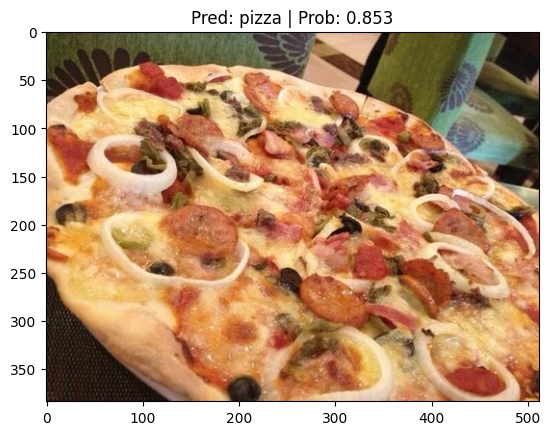

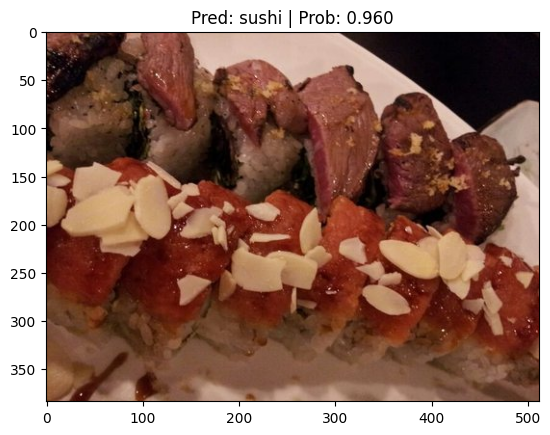

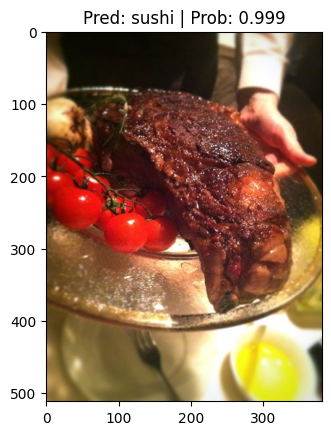

In [53]:
import random
num_image_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_image_to_plot)
for image_path in test_image_path_sample:
  pred_and_plotimage(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

data/04-pizza-dad.jpeg already exists, skipping download.


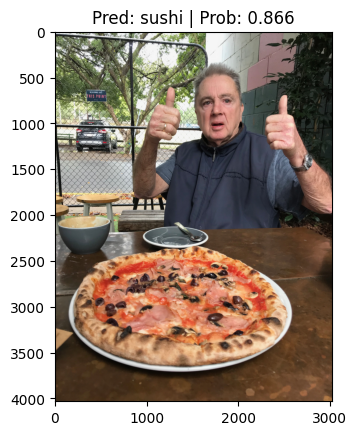

In [55]:
# make predictions on a  custom image
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

pred_and_plotimage(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

hhhhhhhhhhhhhh our model definitly must be enhanced but for training we will accept this result

## Exercises

All of the exercises are focused on practicing the code above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**
* [Exercise template notebook for 06](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb)
* [Example solutions notebook for 06](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb) (try the exercises *before* looking at this)
    * See a live [video walkthrough of the solutions on YouTube](https://youtu.be/ueLolShyFqs) (errors and all)

1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.
2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
    * Predicting across all of the test dataset, storing the labels and predicted probabilities.
    * Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
    * Plot the top 5 "most wrong" images, why do you think the model got these wrong?
3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
4. Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?
5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
    * You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).
6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
    * You'll have to change the size of the classifier layer to suit our problem.
    * You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  
## Extra-curriculum
* Look up what "model fine-tuning" is and spend 30-minutes researching different methods to perform it with PyTorch. How would we change our code to fine-tine? Tip: fine-tuning usually works best if you have *lots* of custom data, where as, feature extraction is typically better if you have less custom data.
* Check out the new/upcoming [PyTorch multi-weights API](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/) (still in beta at time of writing, May 2022), it's a new way to perform transfer learning in PyTorch. What changes to our code would need to made to use the new API?
* Try to create your own classifier on two classes of images, for example, you could collect 10 photos of your dog and your friends dog and train a model to classify the two dogs. This would be a good way to practice creating a dataset as well as building a model on that dataset.

# **2. Experiment Tracking**
---